In [1]:
import jax.numpy as jnp
import numpy as onp
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
import pandas as pd
from plotnine import *
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("../../models")
from linear_cr_new import LinearContrastiveRegression
# from linear_cr import LinearCR

In [2]:
n = 500
m = 500
p = 2
d = 1


n_repititions = 100
R2_est = []
WWT_diff = []
SST_diff = []
Beta_est = []
Beta_diff = []
Tau2_diff = []
Sigma2_diff = []

for ii in range(n_repititions):
    
    if ii % 10 == 0:
        print(ii)
    zx = onp.random.normal(size=(n, d))
    zy = onp.random.normal(size=(m, d))
    t = onp.random.normal(size=(n, d))
    # W = onp.random.normal(size=(d, p))
    W = onp.array([[1,1]])
    # S = onp.random.normal(size=(d, p))
    S = onp.array([[-1,1]])
    # beta = onp.random.normal(size=(d, 1))
    beta = onp.array([[1]])
    sigma = 1e-2
    sigma2 = sigma**2 # true sigma2=1e-4
    tau = 1e-2
    tau2 = tau**2 # true tau2=1e-4

    X = zx @ S + t @ W + onp.random.normal(scale=sigma, size=(n, p))
    Y = zy @ S + onp.random.normal(scale=sigma, size=(m, p))
    R = t @ beta + onp.random.normal(scale=tau, size=(n, 1))

    model = LinearContrastiveRegression()
    model.fit(X, Y, R, d, seed = ii, verbose = False)

    preds = model.predict(X)
    
    _, _, r2_contrastivereg, _, _ = linregress(R.squeeze(), preds)
    R2_est.append(r2_contrastivereg)
    
    Beta_est.append(model.beta.flatten().item())
    
    
    Sigma2_diff.append((model.sigma_sq - sigma2).flatten().item())
    Tau2_diff.append((model.tau_sq - tau2).flatten().item())
    Beta_diff.append((abs(model.beta) - beta).flatten().item())
    
    WWT_diff.append(onp.linalg.norm(model.W.T @ model.W - W.T @ W, ord = 2)/onp.linalg.norm(W.T @ W, ord = 2))
    SST_diff.append(onp.linalg.norm(model.S.T @ model.S - S.T @ S, ord = 2)/onp.linalg.norm(S.T @ S, ord = 2))


0
10
20
30
40
50
60
70
80
90


In [3]:
df = pd.DataFrame(data={'experiment': list(range(n_repititions)),
                        'Tau_sq': Tau2_diff, 'Sigma_sq': Sigma2_diff, 'Beta': Beta_diff,
                        'W': WWT_diff, 'S': SST_diff, 'R_sq': R2_est
                       })
df_long = pd.melt(df, id_vars='experiment', value_vars=['Tau_sq', 'Sigma_sq', 'Beta', 'W','S'],
                  var_name='param', value_name='diff')
df_long['param'] = df_long['param'].astype('category')
df_long['param'].cat.reorder_categories(['Beta', 'Tau_sq', 'Sigma_sq', 'S', 'W'], inplace=True)


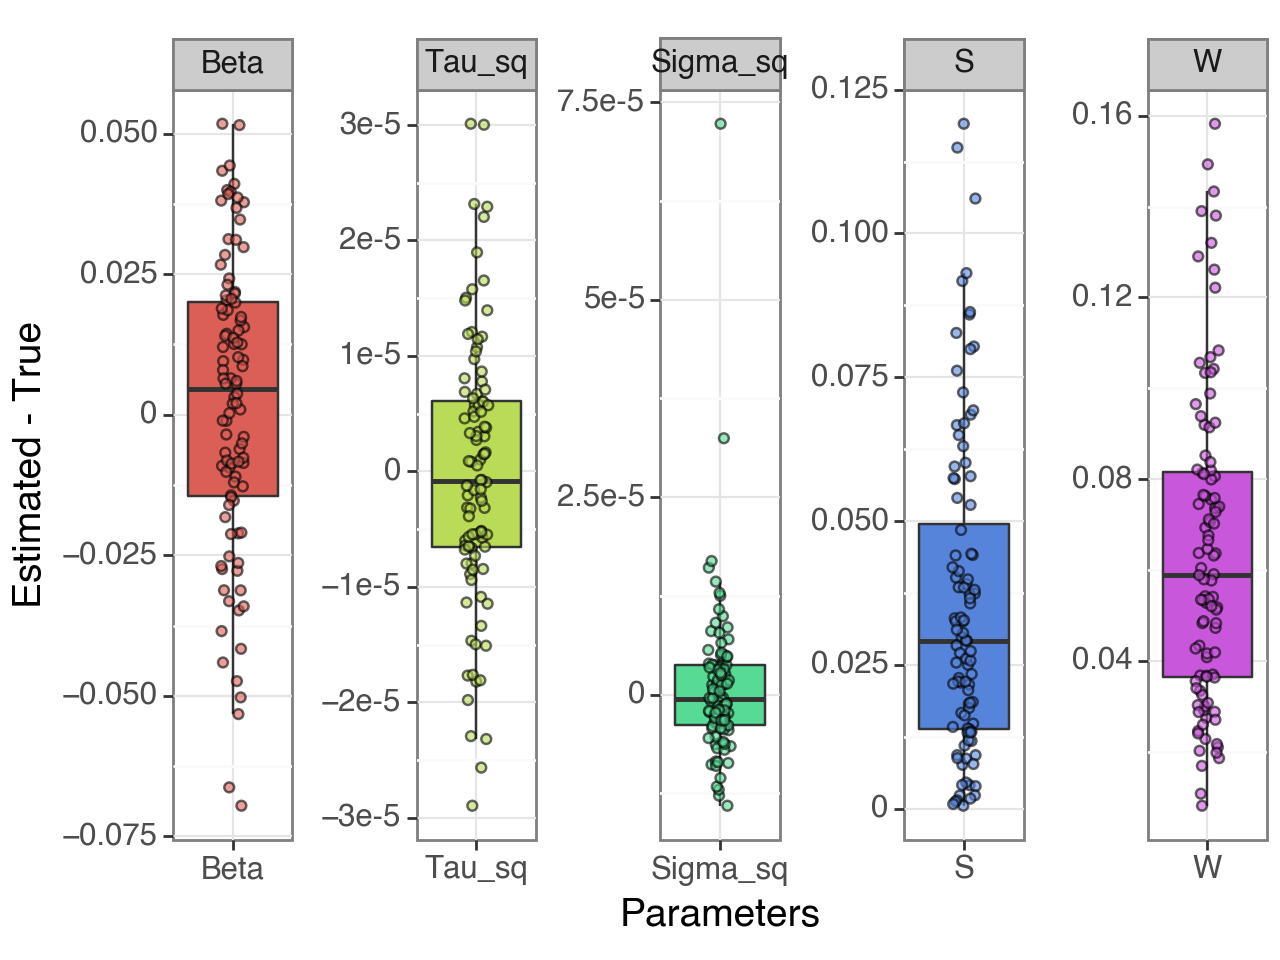

<Figure Size: (640 x 480)>

In [7]:
# plot
p = (
    ggplot(df_long) + aes(x="param", y="diff", fill = "param")
    + geom_boxplot(outlier_shape = "")
    + geom_jitter(alpha = 0.6, width = 0.1)
    + facet_wrap('param',
                 ncol = 5,
                 scales = 'free'
                )
    + xlab("Parameters")
    + ylab("Estimated - True")
    + theme_bw(base_size = 14)
    + theme(legend_position = 'none')
)
p

In [8]:
p.save(filename = './out/simulation_est_error.png', width = 10, height = 4, units = 'in', dpi = '300')